In [ ]:
import pickle
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score,make_scorer
from sklearn.metrics import classification_report, roc_auc_score

from tensorflow.keras.layers import Input, Reshape, Bidirectional, GRU, Convolution1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import models, optimizers
from keras.layers import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/KHMT0119/Đồ Án KHMT0119/Đồ Án Tốt Nghiệp/Data DA/VNNV_Pyvi.csv'

In [ ]:
df = pd.read_csv(path)
df

,Text,Label
0,ban quản_lý dự_án oda thành_phố thơ tết nguyên...,Chính trị Xã hội
1,luật lao_động thành_phố thơ tổ_chức gắn biển c...,Chính trị Xã hội
2,chiều nguyễn đình chiểu thường_trực hội_đồng n...,Chính trị Xã hội
3,sở lao_động thương_binh xã_hội thành_phố thơ p...,Chính trị Xã hội
4,vĩnh_thạnh đầu ủy đảng huyện quan_tâm lãnh_đạo...,Chính trị Xã hội
...,...,...
14498,hôm_qua hà nội phòng cảnh_sát phòng_chống tội_...,Pháp luật
14499,tình_hình giá_cả mặt_hàng lương_thực thực_phẩm...,Pháp luật
14500,thông_tin công_an nguyễn trí sinh tạm giam cáo...,Pháp luật
14501,hôm_qua ngày_tháng công_an thành_phố long xuyê...,Pháp luật


# Word Count

In [ ]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df['Word_Count'] = df['Text'].apply(lambda x: len(word_tokenize(x)))

In [ ]:
average_word_count = df['Word_Count'].mean()

print(f"Số lượng trung bình của các từ trong câu: {average_word_count}")

Số lượng trung bình của các từ trong câu: 145.24594911397642


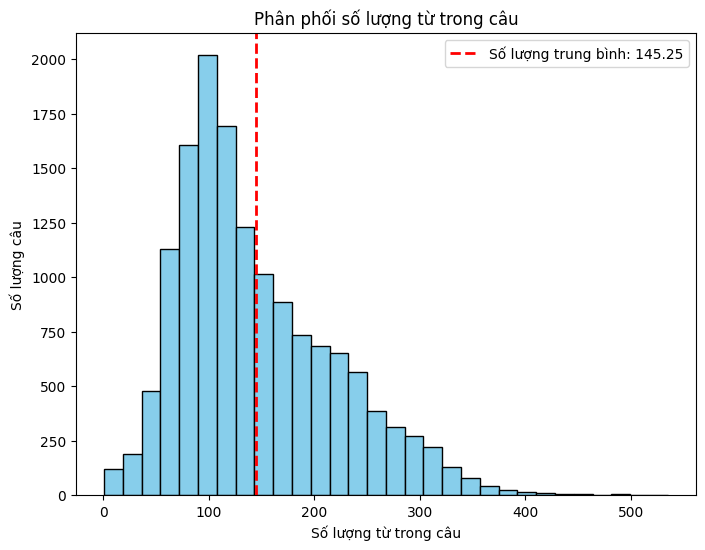

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['Word_Count'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(average_word_count, color='red', linestyle='dashed', linewidth=2, label=f'Số lượng trung bình: {average_word_count:.2f}')
plt.xlabel('Số lượng từ trong câu')
plt.ylabel('Số lượng câu')
plt.legend()
plt.title('Phân phối số lượng từ trong câu')
plt.show()

# Train- Test

In [ ]:
X = df['Text']
y = df['Label']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print(f"Train set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Test set size: {len(X_valid)} samples")

Train set size: 10152 samples
Test set size: 1451 samples
Test set size: 2900 samples


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_n = encoder.fit_transform(y_train)
y_test_n = encoder.fit_transform(y_test)
y_valid_n = encoder.fit_transform(y_valid)

taget_name = encoder.classes_

# 1.TF-IDF N-gram(1,1)

In [ ]:
tfidf_vect_1 = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_vect_1.fit(X_train)

X_train_tfidf_1 =  tfidf_vect_1.transform(X_train)
X_test_tfidf_1 =  tfidf_vect_1.transform(X_test)
X_valid_tfidf_1 = tfidf_vect_1.transform(X_valid)

In [ ]:
print("Vector hoá tập Train TF-IDF ",X_train_tfidf_1.data)
print("------------------")
print("Kích thước vector ",X_train_tfidf_1.shape)

Vector hoá tập Train TF-IDF  [0.10733548 0.07425398 0.05719422 ... 0.08768774 0.03331469 0.05640034]
------------------
Kích thước vector  (10152, 30162)


## SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf_1)

X_train_tfidf_svd_1 = svd.transform(X_train_tfidf_1)
X_test_tfidf_svd_1 = svd.transform(X_test_tfidf_1)
X_valid_tfidf_svd_1 = svd.transform(X_valid_tfidf_1)

# CNN

In [ ]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Bidirectional, GRU, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

early_stopping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

In [ ]:
def create_rcnn1_model():
    input_layer = Input(shape=(300,))

    layer = Reshape((10, 30))(input_layer)
    layer = Bidirectional(GRU(128, activation='relu', return_sequences=True))(layer)
    layer = Conv1D(100, 3, activation="relu")(layer)
    layer = Flatten()(layer)
    layer = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(256, activation='relu', )(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)

    output_layer = Dense(11, activation='softmax')(layer)

    classifier = Model(input_layer, output_layer)

    optimizer = Adam()

    classifier.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping with restore_best_weights
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    return classifier, [early_stopping, reduce_lr]

    # Learning rate schedule
    def lr_schedule(epoch):
        return 0.001 * 0.9 ** epoch

    learning_rate_scheduler = LearningRateScheduler(lr_schedule)

    return classifier, [early_stopping, learning_rate_scheduler]

# Sử dụng hàm để tạo mô hình và callback
model, callbacks = create_rcnn1_model()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 10, 30)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 10, 256)           122880    
 onal)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 100)            76900     
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               410112    
                                                           

In [ ]:
history = model.fit(X_train_tfidf_svd_1, y_train_n,
                    validation_data=(X_valid_tfidf_svd_1, y_valid_n),
                    epochs=100, batch_size=32, verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
318/318 - 23s - loss: 2.3108 - accuracy: 0.2670 - val_loss: 1.6674 - val_accuracy: 0.4003 - lr: 0.0010 - 23s/epoch - 74ms/step
Epoch 2/100
318/318 - 14s - loss: 1.4187 - accuracy: 0.4879 - val_loss: 1.1457 - val_accuracy: 0.6390 - lr: 0.0010 - 14s/epoch - 45ms/step
Epoch 3/100
318/318 - 14s - loss: 0.8854 - accuracy: 0.7746 - val_loss: 0.7411 - val_accuracy: 0.8083 - lr: 0.0010 - 14s/epoch - 44ms/step
Epoch 4/100
318/318 - 16s - loss: 0.6716 - accuracy: 0.8330 - val_loss: 0.7016 - val_accuracy: 0.8252 - lr: 0.0010 - 16s/epoch - 50ms/step
Epoch 5/100
318/318 - 15s - loss: 0.5975 - accuracy: 0.8476 - val_loss: 0.6529 - val_accuracy: 0.8424 - lr: 0.0010 - 15s/epoch - 47ms/step
Epoch 6/100
318/318 - 15s - loss: 0.5575 - accuracy: 0.8612 - val_loss: 0.6058 - val_accuracy: 0.8507 - lr: 0.0010 - 15s/epoch - 48ms/step
Epoch 7/100
318/318 - 15s - loss: 0.5251 - accuracy: 0.8675 - val_loss: 0.6057 - val_accuracy: 0.8541 - lr: 0.0010 - 15s/epoch - 47ms/step
Epoch 8/100
318/318 - 15s -

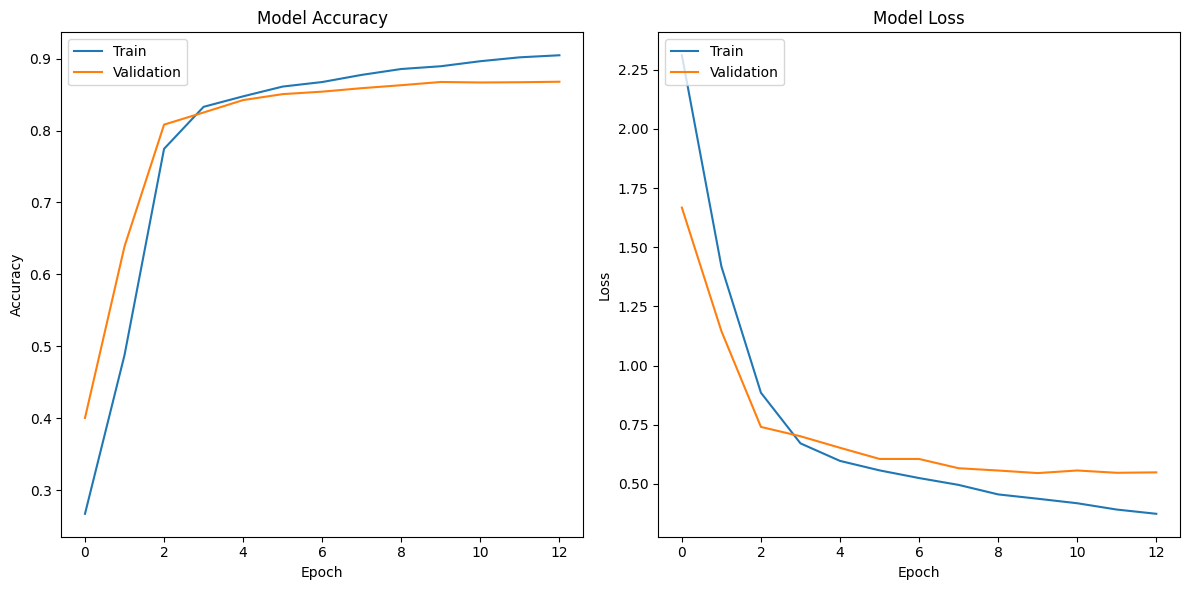

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_predictions = model.predict(X_test_tfidf_svd_1)
test_predictions = test_predictions.argmax(axis=-1)

test_classification_report = classification_report(y_test_n, test_predictions, target_names=taget_name)

print("Test classification report:\n", test_classification_report)

46/46 [==============================] - 0s 7ms/step
Test classification report:
                   precision    recall  f1-score   support

Chính trị Xã hội       0.94      0.76      0.84       131
Dự báo thời tiết       0.99      0.98      0.99       160
        Giáo dục       0.91      0.85      0.88       109
         Kinh tế       0.84      0.87      0.85       140
      Môi trường       0.75      0.93      0.83       105
     Nông nghiệp       0.84      0.94      0.89       152
       Pháp luật       0.89      0.92      0.90       130
        Sức khỏe       0.87      0.89      0.88       111
        Thế giới       0.86      0.83      0.85       145
        Thể thao       0.93      0.91      0.92       135
         Văn hóa       0.85      0.77      0.81       133

        accuracy                           0.88      1451
       macro avg       0.88      0.88      0.88      1451
    weighted avg       0.88      0.88      0.88      1451



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix CNN')
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

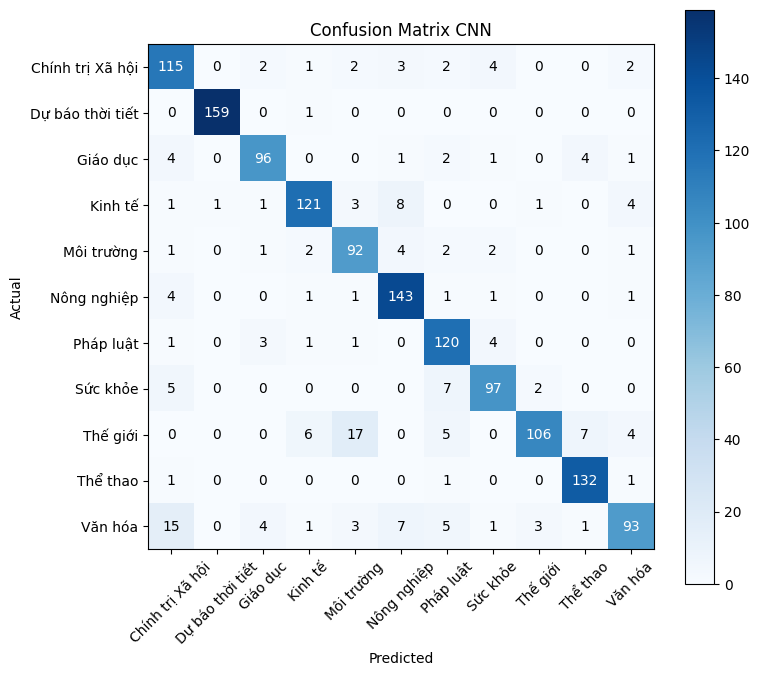

In [ ]:
plot_confusion_matrix(y_test_n, test_predictions, taget_name)